In [1]:
%matplotlib inline
import numpy as np 
import pandas as pd 
import geopandas as gpd 
import matplotlib.pyplot as plt 
import matplotlib 
import folium
import shapely.geometry as shpgeom 
import cartopy.crs as ccrs
from cartopy.io.img_tiles import StamenTerrain
from owslib import fes
from datetime import datetime, timedelta
from ioos_tools.ioos import fes_date_filter, get_csw_records
from owslib.csw import CatalogueServiceWeb
from geolinks import sniff_link
import re
from itertools import cycle
import altair as alt
import vega
from netCDF4 import Dataset
import gridgeo

In [2]:
from ioos_lib import *

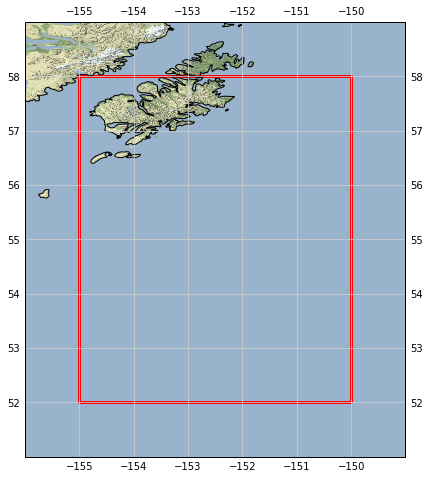

Found 49 records.

68
http://oos.soest.hawaii.edu/thredds/dodsC/hioos/model/atm/ncep_global/NCEP_Global_Atmospheric_Model_best.ncd
{'SG610-20180719T1146': <GridGeo: unknown_2d>, 'CMOP Virtual Columbia River (SELFE); f33': <GridGeo: ugrid>, 'COAWST Modeling System: USEast: ROMS-WRF-SWAN coupled model (aka CNAPS)': <GridGeo: unknown_2d>, 'Coupled Northwest Atlantic Prediction System (CNAPS)': <GridGeo: unknown_2d>, 'GLCFS - Lake Erie - Forecast - 3D': <GridGeo: unknown_2d>, 'GLCFS - Lake Huron - Forecast - 3D': <GridGeo: unknown_2d>, 'GLCFS - Lake Michigan - Forecast - 3D': <GridGeo: unknown_2d>, 'GLCFS - Lake Ontario - Forecast - 3D': <GridGeo: unknown_2d>, 'GLCFS - Lake Superior - Forecast - 3D': <GridGeo: unknown_2d>, 'Great Lakes Coastal Forecasting System (GLCFS), NOWCAST': <GridGeo: unknown_2d>, 'https://ecowatch.ncddc.noaa.gov/thredds/dodsC/hycom/hycom_sfc_agg/HYCOM_Surface_Aggregation_best.ncd': <GridGeo: unknown_1d>, 'Regional Ocean Modeling System (ROMS): Main Hawaiian Islands'

In [3]:
# ds = DataScraper([-127, -123.75, 43, 48])
days = 20
now_datetime_utc = datetime.utcnow()
start = now_datetime_utc - timedelta(days=days)
stop = now_datetime_utc + timedelta(days=days)

ds = DataScraper([-155, -150, 52, 58], start, stop, ['sea_water_temperature','sea_surface_temperature', 'sea_water_potential_temperature','equivalent_potential_temperature','sea_water_conservative_temperature','pseudo_equivalent_potential_temperature'],models_only=True)
ds.draw_roi()
plt.show()
ds.make_bbox()
ds.make_fes_filter()
ds.get_records()
ds.create_database()
# ds.get_observations()
ds.get_models()
# ds.plot_observations('sea_water_temperature (C)')

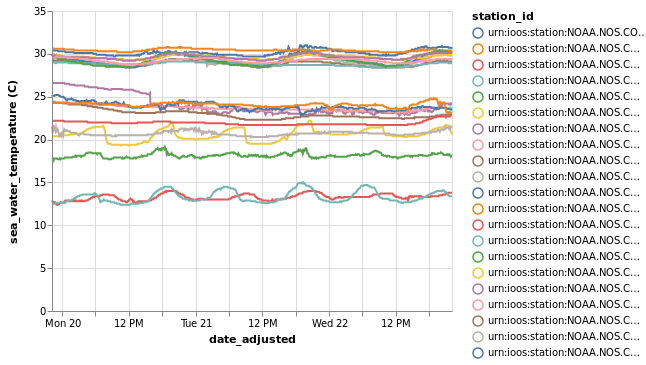

In [90]:
alt.renderers.enable('notebook')
obs = ds.observations
charts = []
m = alt.LayerChart()
for k,series in enumerate(obs):
    series['time'] = pd.to_datetime(series.index,infer_datetime_format=True)
    m+=alt.Chart(series).mark_line().encode(x='time:T',y='sea_water_temperature (C)', color='station_id')
m

In [153]:
tiles = 'http://services.arcgisonline.com/arcgis/rest/services/Ocean/World_Ocean_Base/MapServer/tile/{z}/{y}/{x}'
m = folium.Map(tiles=tiles, attr='ESRI')
for title, grid in ds.grids.items():
    try:
        print('Loading...')
        gj = folium.GeoJson(grid.outline.__geo_interface__, name=title)
        folium.Popup(title).add_to(gj)
        gj.add_to(m)
    except Exception:
        print(f'Could not compute grid outline for {title}')

Loading...
Loading...
Loading...
Loading...
Loading...
Loading...
Loading...
Loading...
Loading...
Loading...
Loading...
Loading...
Loading...
Loading...
Loading...


In [158]:
# query_bbox_shp = shpgeom.box(ds.min_lon, ds.min_lat, ds.max_lon, ds.max_lat)
# folium.GeoJson(query_bbox_shp.__geo_interface__,
#       style_function=lambda feature: {'color': 'red', 'fillOpacity': 0.0}
#       ).add_to(m)
# folium.LayerControl().add_to(m)
# m.fit_bounds(m.get_bounds())
m

In [150]:
import xarray as xr
print(len(ds.good_urls))
mods = xr.open_dataset(ds.good_urls[17])
mods

18


<xarray.Dataset>
Dimensions:         (boundary: 4, eta_psi: 81, eta_rho: 82, eta_u: 82, eta_v: 81, ocean_time: 1, s_rho: 36, s_w: 37, time: 1924, tracer: 2, xi_psi: 129, xi_rho: 130, xi_u: 129, xi_v: 130)
Coordinates:
  * s_rho           (s_rho) float64 -0.9861 -0.9583 -0.9306 -0.9028 -0.875 ...
  * s_w             (s_w) float64 -1.0 -0.9722 -0.9444 -0.9167 -0.8889 ...
    lon_rho         (eta_rho, xi_rho) float64 ...
    lat_rho         (eta_rho, xi_rho) float64 ...
    lon_u           (eta_u, xi_u) float64 ...
    lat_u           (eta_u, xi_u) float64 ...
    lon_v           (eta_v, xi_v) float64 ...
    lat_v           (eta_v, xi_v) float64 ...
    lon_psi         (eta_psi, xi_psi) float64 ...
    lat_psi         (eta_psi, xi_psi) float64 ...
  * ocean_time      (ocean_time) datetime64[ns] 2018-06-04T12:00:00
  * time            (time) datetime64[ns] 2013-05-19T12:00:00 ...
    time_run        (time) datetime64[ns] ...
Dimensions without coordinates: boundary, eta_psi, eta_rho, eta_

In [146]:
mods.salt

<xarray.DataArray 'salt' (time: 1924, s_rho: 36, eta_rho: 82, xi_rho: 130)>
[738354240 values with dtype=float32]
Coordinates:
  * s_rho     (s_rho) float64 -0.9861 -0.9583 -0.9306 -0.9028 -0.875 -0.8472 ...
    lon_rho   (eta_rho, xi_rho) float64 ...
    lat_rho   (eta_rho, xi_rho) float64 ...
  * time      (time) datetime64[ns] 2013-05-19T12:00:00 2013-05-20T12:00:00 ...
    time_run  (time) datetime64[ns] ...
Dimensions without coordinates: eta_rho, xi_rho
Attributes:
    long_name:      time-averaged salinity
    time:           ocean_time
    field:          salinity, scalar, series
    _ChunkSizes:    [  1  36  82 130]
    standard_name:  sea_water_salinity

<xarray.DataArray 'salt' (eta_rho: 82, xi_rho: 130)>
array([[36.091537, 36.09706 , 36.102226, ..., 35.306084, 35.239872, 35.26532 ],
       [36.086018, 36.017414, 36.01788 , ..., 35.377094, 35.30367 , 35.290768],
       [36.101425, 36.04081 , 36.039116, ..., 35.433125, 35.368313, 35.39109 ],
       ...,
       [      nan,       nan,       nan, ...,       nan,       nan,       nan],
       [      nan,       nan,       nan, ...,       nan,       nan,       nan],
       [      nan,       nan,       nan, ...,       nan,       nan,       nan]],
      dtype=float32)
Coordinates:
    s_rho     float64 -0.01389
    lon_rho   (eta_rho, xi_rho) float64 ...
    lat_rho   (eta_rho, xi_rho) float64 ...
    time      datetime64[ns] 2018-08-24T12:00:00
    time_run  datetime64[ns] ...
Dimensions without coordinates: eta_rho, xi_rho
Attributes:
    long_name:      time-averaged salinity
    time:           ocean_time
    field:          salinity, scalar, series
    _ChunkSizes:    [  1  36  82 130]
  

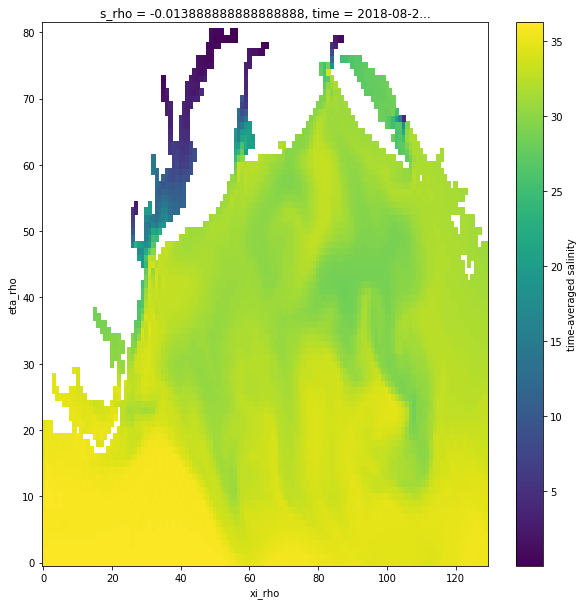

In [148]:
salx = mods.salt.isel(time=-1, s_rho=-1)
print(salx)
salx.plot(figsize=(10,10))

In [43]:
ds.grids

{'West Florida Shelf FVCOM (WFCOM)': <GridGeo: ugrid>,
 'CMOP Virtual Columbia River (SELFE); f33': <GridGeo: ugrid>,
 'COAWST Modeling System: USEast: ROMS-WRF-SWAN coupled model (aka CNAPS)': <GridGeo: unknown_2d>,
 'Coupled Northwest Atlantic Prediction System (CNAPS)': <GridGeo: unknown_2d>,
 'GLCFS - Lake Erie - Forecast - 3D': <GridGeo: unknown_2d>,
 'GLCFS - Lake Huron - Forecast - 3D': <GridGeo: unknown_2d>,
 'GLCFS - Lake Michigan - Forecast - 3D': <GridGeo: unknown_2d>,
 'GLCFS - Lake Ontario - Forecast - 3D': <GridGeo: unknown_2d>,
 'GLCFS - Lake Superior - Forecast - 3D': <GridGeo: unknown_2d>,
 'Great Lakes Coastal Forecasting System (GLCFS), NOWCAST': <GridGeo: unknown_2d>,
 'https://ecowatch.ncddc.noaa.gov/thredds/dodsC/hycom/hycom_sfc_agg/HYCOM_Surface_Aggregation_best.ncd': <GridGeo: unknown_1d>,
 'Regional Ocean Modeling System (ROMS): Main Hawaiian Islands': <GridGeo: unknown_1d>,
 'Regional Ocean Modeling System (ROMS): Main Hawaiian Islands: Data Assimilating': <Gr

In [44]:
ds.dap_urls

['https://data.ioos.us/gliders/erddap/tabledap/SG635-20180716T1248-delayed',
 'http://www.ncdc.noaa.gov/oa/wct/wct-jnlp-beta.php?singlefile=http://data.ioos.us/thredds/dodsC/deployments/aoml/SG635-20180716T1248-delayed/SG635-20180716T1248-delayed.nc3.nc',
 'http://data.ioos.us/thredds/dodsC/deployments/aoml/SG635-20180716T1248-delayed/SG635-20180716T1248-delayed.nc3.nc',
 'http://www.ncdc.noaa.gov/oa/wct/wct-jnlp-beta.php?singlefile=http://data.ioos.us/thredds/dodsC/deployments/aoml/SG649-20180731T1418-delayed/SG649-20180731T1418-delayed.nc3.nc',
 'http://data.ioos.us/thredds/dodsC/deployments/aoml/SG649-20180731T1418-delayed/SG649-20180731T1418-delayed.nc3.nc',
 'https://data.ioos.us/gliders/erddap/tabledap/SG649-20180731T1418-delayed',
 'http://www.ncdc.noaa.gov/oa/wct/wct-jnlp-beta.php?singlefile=http://thredds.cencoos.org/thredds/dodsC/UCSC.nc',
 'http://thredds.cencoos.org/thredds/dodsC/UCSC.nc',
 'http://www.ncdc.noaa.gov/oa/wct/wct-jnlp-beta.php?singlefile=http://thredds.secoora

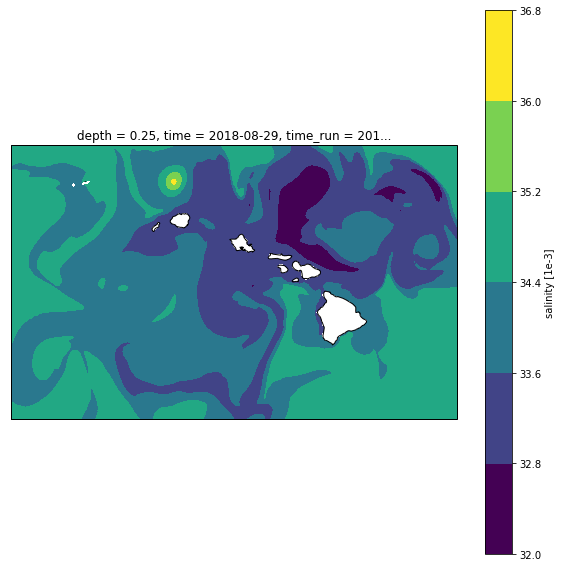

In [140]:
import cartopy.crs as ccrs

fig, ax = plt.subplots(
    figsize=(10, 10),
    subplot_kw={'projection': ccrs.PlateCarree()}
)

salx.plot.contourf(x='lon', y='lat',
    ax=ax,
    transform=ccrs.PlateCarree()
)
ax.coastlines('10m');